In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from dubins_planner import DubinsPath

In [3]:
class Node:
    def __init__(self, x, y, yaw):
        self.x = x
        self.y = y
        self.path_x = []
        self.path_y = []
        self.parent = None
        self.cost = 0.0
        self.yaw = yaw
        self.path_yaw = []

In [4]:
class RRTStarDubins:
    def __init__(self, start, goal, obstacle_list, rand_area,
                 goal_sample_rate=10,
                 max_iter=100,
                 connect_circle_dist=50.0,
                 robot_radius=0.0,
                 ):

        self.start = Node(start[0], start[1], start[2])
        self.end = Node(goal[0], goal[1], goal[2])
        self.min_rand = rand_area[0]
        self.max_rand = rand_area[1]
        self.goal_sample_rate = goal_sample_rate
        self.max_iter = max_iter
        self.obstacle_list = obstacle_list
        self.connect_circle_dist = connect_circle_dist

        self.curvature = 1.0  # for dubins path
        self.goal_yaw_th = np.deg2rad(1.0)
        self.goal_xy_th = 0.5
        self.robot_radius = robot_radius
        self.dubbins_planner = DubinsPath()

    def planning(self, search_until_max_iter=True):

        self.node_list = [self.start]
        for i in range(self.max_iter):
            print("Iter:", i, ", number of nodes:", len(self.node_list))
            rnd = self.get_random_node()
            nearest_ind = self.get_nearest_node_index(self.node_list, rnd)
            new_node = self.steer(self.node_list[nearest_ind], rnd)

            if self.check_collision(new_node, self.obstacle_list, self.robot_radius):
                near_indexes = self.find_near_nodes(new_node)
                new_node = self.choose_parent(new_node, near_indexes)
                if new_node:
                    self.node_list.append(new_node)
                    self.rewire(new_node, near_indexes)

            if (not search_until_max_iter) and new_node:  # check reaching the goal
                last_index = self.search_best_goal_node()
                if last_index:
                    return self.generate_final_course(last_index)

        print("reached max iteration")

        last_index = self.search_best_goal_node()
        if last_index:
            return self.generate_final_course(last_index)
        else:
            print("Cannot find path")

        return None

    def choose_parent(self, new_node, near_inds):
        """
        Computes the cheapest point to new_node contained in the list
        near_inds and set such a node as the parent of new_node.
            Arguments:
            --------
                new_node, Node
                    randomly generated node with a path from its neared point
                    There are not coalitions between this node and th tree.
                near_inds: list
                    Indices of indices of the nodes what are near to new_node

            Returns.
            ------
                Node, a copy of new_node
        """
        if not near_inds:
            return None

        # search nearest cost in near_inds
        costs = []
        for i in near_inds:
            near_node = self.node_list[i]
            t_node = self.steer(near_node, new_node)
            if t_node and self.check_collision(
                    t_node, self.obstacle_list, self.robot_radius):
                costs.append(self.calc_new_cost(near_node, new_node))
            else:
                costs.append(float("inf"))  # the cost of collision node
        min_cost = min(costs)

        if min_cost == float("inf"):
            print("There is no good path.(min_cost is inf)")
            return None

        min_ind = near_inds[costs.index(min_cost)]
        new_node = self.steer(self.node_list[min_ind], new_node)
        new_node.cost = min_cost

        return new_node

    def search_best_goal_node(self):

        goal_indexes = []
        for (i, node) in enumerate(self.node_list):
            if self.calc_dist_to_goal(node.x, node.y) <= self.goal_xy_th:
                goal_indexes.append(i)

        # angle check
        final_goal_indexes = []
        for i in goal_indexes:
            if abs(self.node_list[i].yaw - self.end.yaw) <= self.goal_yaw_th:
                final_goal_indexes.append(i)

        if not final_goal_indexes:
            return None

        min_cost = min([self.node_list[i].cost for i in final_goal_indexes])
        for i in final_goal_indexes:
            if self.node_list[i].cost == min_cost:
                return i

        return None

    def find_near_nodes(self, new_node):
        """"""  """
        1) defines a ball centered on new_node
        2) Returns all nodes of the three that are inside this ball
            Arguments:
            ---------
                new_node: Node
                    new randomly generated node, without collisions between
                    its nearest node
            Returns:
            -------
                list
                    List with the indices of the nodes inside the ball of
                    radius r
        """
        nnode = len(self.node_list) + 1
        r = self.connect_circle_dist * np.sqrt(np.log(nnode) / nnode)

        dist_list = [(node.x - new_node.x)**2 + (node.y - new_node.y)**2
                     for node in self.node_list]
        near_inds = [dist_list.index(i) for i in dist_list if i <= r**2]
        return near_inds

    def rewire(self, new_node, near_inds):
        """
            For each node in near_inds, this will check if it is cheaper to
            arrive to them from new_node.
            In such a case, this will re-assign the parent of the nodes in
            near_inds to new_node.
            Parameters:
            ----------
                new_node, Node
                    Node randomly added which can be joined to the tree

                near_inds, list of uints
                    A list of indices of the self.new_node which contains
                    nodes within a circle of a given radius.
            Remark: parent is designated in choose_parent.

        """
        for i in near_inds:
            near_node = self.node_list[i]
            edge_node = self.steer(new_node, near_node)
            if not edge_node:
                continue
            edge_node.cost = self.calc_new_cost(new_node, near_node)

            no_collision = self.check_collision(
                edge_node, self.obstacle_list, self.robot_radius)
            improved_cost = near_node.cost > edge_node.cost

            if no_collision and improved_cost:
                for node in self.node_list:
                    if node.parent == near_node:
                        node.parent = edge_node
                self.near_node = edge_node
                self.propagate_cost_to_leaves(self.near_node)

    def calc_new_cost(self, from_node, to_node):

        _, _, _, _, course_lengths = self.dubbins_planner.plan_dubins_path(
            from_node.x, from_node.y, from_node.yaw,
            to_node.x, to_node.y, to_node.yaw, self.curvature)

        cost = sum([abs(c) for c in course_lengths])

        return from_node.cost + cost

    def propagate_cost_to_leaves(self, parent_node):

        for node in self.node_list:
            if node.parent == parent_node:
                node.cost = self.calc_new_cost(parent_node, node)
                self.propagate_cost_to_leaves(node)

    def steer(self, from_node, to_node):

        px, py, pyaw, mode, course_lengths = \
            self.dubbins_planner.plan_dubins_path(
                from_node.x, from_node.y, from_node.yaw,
                to_node.x, to_node.y, to_node.yaw, self.curvature)

        if len(px) <= 1:  # cannot find a dubins path
            return None

        # new_node = copy.deepcopy(from_node)
        new_node = Node(px[-1], py[-1], pyaw[-1])
        # new_node.x = px[-1]
        # new_node.y = py[-1]
        # new_node.yaw = pyaw[-1]

        new_node.path_x = px
        new_node.path_y = py
        new_node.path_yaw = pyaw
        new_node.cost += sum([abs(c) for c in course_lengths])
        new_node.parent = from_node

        return new_node

    def generate_final_course(self, goal_index):
        print("final")
        path = [[self.end.x, self.end.y]]
        node = self.node_list[goal_index]
        while node.parent:
            for (ix, iy) in zip(reversed(node.path_x), reversed(node.path_y)):
                path.append([ix, iy])
            node = node.parent
        path.append([self.start.x, self.start.y])
        return path

    def calc_dist_to_goal(self, x, y):
        dx = x - self.end.x
        dy = y - self.end.y
        return np.hypot(dx, dy)

    def get_random_node(self):

        if np.random.randint(0, 100) > self.goal_sample_rate:
            rnd = Node(np.random.uniform(self.min_rand, self.max_rand),
                       np.random.uniform(self.min_rand, self.max_rand),
                       np.random.uniform(-np.pi, np.pi)
                       )
        else:  # goal point sampling
            rnd = Node(self.end.x, self.end.y, self.end.yaw)

        return rnd

    @staticmethod
    def get_nearest_node_index(node_list, rnd_node):
        dlist = [(node.x - rnd_node.x)**2 + (node.y - rnd_node.y)**2
                 for node in node_list]
        minind = dlist.index(min(dlist))

        return minind

    @staticmethod
    def check_collision(node, obstacleList, robot_radius):

        if node is None:
            return False

        for (ox, oy, size) in obstacleList:
            dx_list = [ox - x for x in node.path_x]
            dy_list = [oy - y for y in node.path_y]
            d_list = [dx * dx + dy * dy for (dx, dy) in zip(dx_list, dy_list)]

            if min(d_list) <= (size+robot_radius)**2:
                return False  # collision

        return True  # safe

    @staticmethod
    def calc_distance_and_angle(from_node, to_node):
        dx = to_node.x - from_node.x
        dy = to_node.y - from_node.y
        d = np.hypot(dx, dy)
        theta = np.arctan2(dy, dx)
        return d, theta

In [29]:
# np.random.seed(13)

obstacleList = [
    (5.5, 5, 1),
    (3, 6, 2),
    (3, 8, 2),
    (3, 10, 2),
    (7, 5, 2),
    (9, 5, 2)
]  # [x,y,size(radius)]

# Set Initial parameters
start = [-1.0, -1.0, np.deg2rad(10.0)]
goal = [10.0, 10.0, np.deg2rad(0.0)]

rnd_min = 0
rnd_max = 15

rrtstar_dubins = RRTStarDubins(start, goal, rand_area=[
                               rnd_min, rnd_max], obstacle_list=obstacleList, robot_radius=0.5)
path = rrtstar_dubins.planning(search_until_max_iter=False)

Iter: 0 , number of nodes: 1
Iter: 1 , number of nodes: 1
Iter: 2 , number of nodes: 1
Iter: 3 , number of nodes: 2
Iter: 4 , number of nodes: 2
Iter: 5 , number of nodes: 3
Iter: 6 , number of nodes: 4
Iter: 7 , number of nodes: 4
Iter: 8 , number of nodes: 4
Iter: 9 , number of nodes: 4
Iter: 10 , number of nodes: 5
Iter: 11 , number of nodes: 6
final


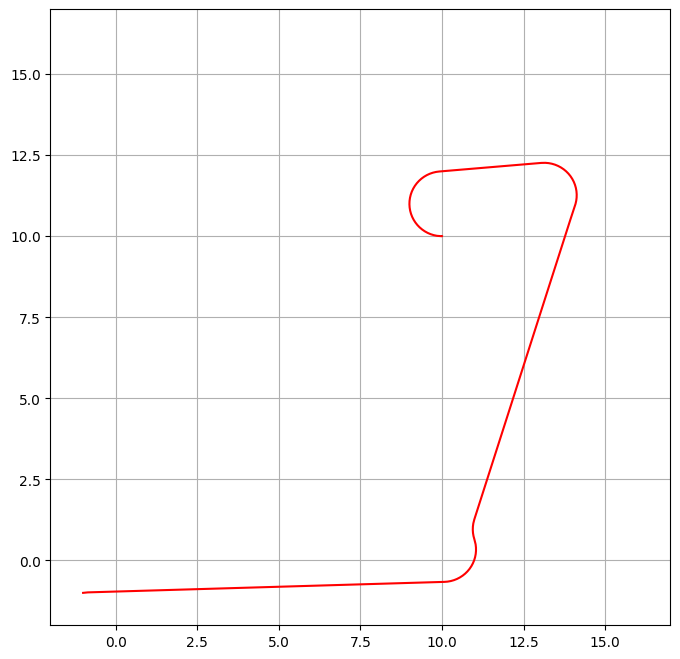

In [30]:
# rrtstar_dubins.draw_graph()
plt.figure(figsize=(8, 8))
plt.xlim(-2, 17)
plt.ylim(-2, 17)
plt.plot([x for (x, y) in path], [y for (x, y) in path], '-r')
# plt.scatter([x for (x, y) in path], [y for (x, y) in path])
plt.grid(True)
plt.show()

In [7]:
path

[[10.0, 10.0],
 [9.999999999999996, 9.999999999999996],
 [9.88139429507992, 9.992941431686887],
 [9.782858093923288, 9.9761400476496],
 [9.686491502914603, 9.949585394925204],
 [9.593257385176667, 9.913542798825908],
 [9.50408730519481, 9.868372385057846],
 [9.419872220932506, 9.814525481464035],
 [9.341453581673896, 9.752540108505759],
 [9.269614920540695, 9.683035603539981],
 [9.205074025688246, 9.606706432605185],
 [9.148475768403527, 9.52431525154628],
 [9.100385659764433, 9.436685285809503],
 [9.061284200240006, 9.344692105045882],
 [9.031562078688596, 9.249254874708704],
 [9.011516268723913, 9.151327172056142],
 [9.001347061452861, 9.051887458322511],
 [9.001156064233001, 8.951929302257033],
 [9.010945185445415, 8.85245145271334],
 [9.030616615426807, 8.754447859481074],
 [9.059973803751308, 8.658897742068127],
 [9.098723423097379, 8.566755805663018],
 [9.146478300077433, 8.478942702036234],
 [9.202761283746351, 8.396335830692061],
 [9.267010013135994, 8.31976057218277],
 [9.3385

In [8]:
path_cpp = [[10, 10],
            [10, 10],
            [9.80308, 10.0196],
            [9.70619, 10.0441],
            [9.61223, 10.0782],
            [9.52214, 10.1216],
            [9.43683, 10.1737],
            [9.35715, 10.234],
            [9.28389, 10.302],
            [9.21778, 10.377],
            [9.13103, 10.4859],
            [9.06873, 10.5641],
            [9.00643, 10.6424],
            [8.94413, 10.7206],
            [8.88183, 10.7988],
            [8.81953, 10.877],
            [8.75723, 10.9552],
            [8.69493, 11.0335],
            [8.63263, 11.1117],
            [8.57033, 11.1899],
            [8.50803, 11.2681],
            [8.44573, 11.3463],
            [8.38343, 11.4246],
            [8.32112, 11.5028],
            [8.25882, 11.581],
            [8.19652, 11.6592],
            [8.13422, 11.7375],
            [8.07192, 11.8157],
            [8.00962, 11.8939],
            [7.94732, 11.9721],
            [7.88502, 12.0503],
            [7.82272, 12.1286],
            [7.76042, 12.2068],
            [7.69812, 12.285],
            [7.63582, 12.3632],
            [7.57351, 12.4414],
            [7.47868, 12.5841],
            [7.4351, 12.674],
            [7.40072, 12.7679],
            [7.37588, 12.8647],
            [7.36084, 12.9635],
            [7.35573, 13.0634],
            [7.36062, 13.1632],
            [7.37544, 13.262],
            [7.40007, 13.3589],
            [7.43424, 13.4529],
            [7.47762, 13.5429],
            [7.52977, 13.6282],
            [7.59018, 13.7078],
            [7.65823, 13.781],
            [7.73325, 13.8471],
            [7.8145, 13.9053],
            [7.90115, 13.9552],
            [7.99234, 13.9961],
            [8.08717, 14.0277],
            [8.18467, 14.0497],
            [8.28389, 14.0619],
            [8.38382, 14.0641],
            [8.48348, 14.0563],
            [8.58185, 14.0386],
            [8.67797, 14.0111],
            [8.77087, 13.9742],
            [8.85962, 13.9282],
            [8.94334, 13.8736],
            [9.02118, 13.8109],
            [9.09238, 13.7407],
            [9.15621, 13.6638],
            [9.21205, 13.5809],
            [9.25933, 13.4928],
            [9.29758, 13.4005],
            [9.32642, 13.3048],
            [9.34557, 13.2067],
            [9.35482, 13.1071],
            [9.35409, 13.0072],
            [9.34338, 12.9078],
            [9.33143, 12.7791],
            [9.33363, 12.6791],
            [9.34581, 12.5799],
            [9.36782, 12.4824],
            [9.39947, 12.3876],
            [9.44041, 12.2964],
            [9.49026, 12.2098],
            [9.54851, 12.1285],
            [9.6381, 12.0159],
            [9.70036, 11.9377],
            [9.76262, 11.8594],
            [9.82489, 11.7812],
            [9.88715, 11.7029],
            [9.94941, 11.6247],
            [10.0117, 11.5464],
            [10.0739, 11.4682],
            [10.1362, 11.3899],
            [10.1985, 11.3117],
            [10.2607, 11.2334],
            [10.323, 11.1552],
            [10.3852, 11.0769],
            [10.4475, 10.9987],
            [10.5098, 10.9204],
            [10.572, 10.8421],
            [10.6343, 10.7639],
            [10.6966, 10.6856],
            [10.7588, 10.6074],
            [10.8211, 10.5291],
            [10.8833, 10.4509],
            [10.9456, 10.3726],
            [11.0079, 10.2944],
            [11.0701, 10.2161],
            [11.1324, 10.1379],
            [11.1946, 10.0596],
            [11.2569, 9.98137],
            [11.3192, 9.90311],
            [11.3814, 9.82486],
            [11.4437, 9.74661],
            [11.506, 9.66836],
            [11.5682, 9.5901],
            [11.6305, 9.51185],
            [11.6927, 9.4336],
            [11.755, 9.35535],
            [11.8173, 9.27709],
            [11.8795, 9.19884],
            [11.9418, 9.12059],
            [12.004, 9.04233],
            [12.0663, 8.96408],
            [12.1286, 8.88583],
            [12.1908, 8.80758],
            [12.2531, 8.72932],
            [12.3154, 8.65107],
            [12.3776, 8.57282],
            [12.4399, 8.49457],
            [12.5021, 8.41631],
            [12.5644, 8.33806],
            [12.6267, 8.25981],
            [12.6889, 8.18156],
            [12.7512, 8.1033],
            [12.8134, 8.02505],
            [12.8757, 7.9468],
            [12.938, 7.86855],
            [13.0002, 7.79029],
            [13.0625, 7.71204],
            [13.1248, 7.63379],
            [13.187, 7.55553],
            [13.2493, 7.47728],
            [13.3115, 7.39903],
            [13.3738, 7.32078],
            [13.4361, 7.24252],
            [13.4983, 7.16427],
            [13.5606, 7.08602],
            [13.6229, 7.00777],
            [13.6851, 6.92951],
            [13.7474, 6.85126],
            [13.8096, 6.77301],
            [13.8719, 6.69476],
            [13.9342, 6.6165],
            [13.9964, 6.53825],
            [14.0587, 6.46],
            [14.1209, 6.38175],
            [14.1832, 6.30349],
            [14.2455, 6.22524],
            [14.3077, 6.14699],
            [14.37, 6.06873],
            [14.4323, 5.99048],
            [14.4945, 5.91223],
            [14.5568, 5.83398],
            [14.619, 5.75572],
            [14.6813, 5.67747],
            [14.7436, 5.59922],
            [14.8058, 5.52097],
            [14.8681, 5.44271],
            [14.9303, 5.36446],
            [14.9926, 5.28621],
            [15.0549, 5.20796],
            [15.1171, 5.1297],
            [15.1794, 5.05145],
            [15.2417, 4.9732],
            [15.3039, 4.89495],
            [15.3662, 4.81669],
            [15.4284, 4.73844],
            [15.4907, 4.66019],
            [15.553, 4.58193],
            [15.6152, 4.50368],
            [15.6775, 4.42543],
            [15.7398, 4.34718],
            [15.802, 4.26892],
            [15.8643, 4.19067],
            [15.9265, 4.11242],
            [15.9888, 4.03417],
            [16.0511, 3.94653],
            [16.1003, 3.85951],
            [16.1406, 3.76802],
            [16.1715, 3.67296],
            [16.1928, 3.5753],
            [16.2042, 3.47599],
            [16.2056, 3.37604],
            [16.1971, 3.27645],
            [16.1787, 3.17821],
            [16.1505, 3.0823],
            [16.1129, 2.98967],
            [16.0663, 2.90127],
            [16.011, 2.81796],
            [15.9478, 2.74058],
            [15.8771, 2.66991],
            [15.7997, 2.60665],
            [15.7164, 2.55143],
            [15.6279, 2.5048],
            [15.5353, 2.46723],
            [15.4394, 2.4391],
            [15.3411, 2.42069],
            [15.2416, 2.41217],
            [15.1416, 2.41364],
            [15.0423, 2.42508],
            [14.9446, 2.44638],
            [14.8496, 2.47732],
            [14.7581, 2.5176],
            [14.6711, 2.56681],
            [14.5894, 2.62446],
            [14.5139, 2.68997],
            [14.4454, 2.76269],
            [14.3089, 2.89494],
            [14.2278, 2.95337],
            [14.1412, 3.00342],
            [14.0501, 3.04458],
            [13.9554, 3.07643],
            [13.8579, 3.09867],
            [13.7587, 3.11107],
            [13.6588, 3.11351],
            [13.5591, 3.10595],
            [13.4607, 3.08849],
            [13.3054, 3.05282],
            [13.2079, 3.03045],
            [13.1104, 3.00808],
            [13.013, 2.9857],
            [12.9155, 2.96333],
            [12.818, 2.94096],
            [12.7206, 2.91859],
            [12.6231, 2.89621],
            [12.5256, 2.87384],
            [12.4282, 2.85147],
            [12.3307, 2.8291],
            [12.2332, 2.80672],
            [12.1358, 2.78435],
            [12.0383, 2.76198],
            [11.9408, 2.73961],
            [11.8434, 2.71723],
            [11.7459, 2.69486],
            [11.6484, 2.67249],
            [11.551, 2.65012],
            [11.4535, 2.62774],
            [11.356, 2.60537],
            [11.2586, 2.583],
            [11.1611, 2.56063],
            [11.0637, 2.53825],
            [10.9662, 2.51588],
            [10.8687, 2.49351],
            [10.7713, 2.47114],
            [10.6738, 2.44876],
            [10.5763, 2.42639],
            [10.4789, 2.40402],
            [10.3814, 2.38165],
            [10.2839, 2.35927],
            [10.1865, 2.3369],
            [10.089, 2.31453],
            [9.99153, 2.29216],
            [9.89407, 2.26978],
            [9.7966, 2.24741],
            [9.69914, 2.22504],
            [9.60167, 2.20267],
            [9.50421, 2.18029],
            [9.40674, 2.15792],
            [9.30928, 2.13555],
            [9.21181, 2.11317],
            [9.11435, 2.0908],
            [9.01688, 2.06843],
            [8.91942, 2.04606],
            [8.82195, 2.02368],
            [8.72448, 2.00131],
            [8.62702, 1.97894],
            [8.52955, 1.95657],
            [8.43209, 1.93419],
            [8.33462, 1.91182],
            [8.23716, 1.88945],
            [8.13969, 1.86708],
            [8.04223, 1.8447],
            [7.94476, 1.82233],
            [7.8473, 1.79996],
            [7.74983, 1.77759],
            [7.65237, 1.75521],
            [7.5549, 1.73284],
            [7.45744, 1.71047],
            [7.35997, 1.6881],
            [7.26251, 1.66572],
            [7.16504, 1.64335],
            [7.06758, 1.62098],
            [6.97011, 1.59861],
            [6.87265, 1.57623],
            [6.77518, 1.55386],
            [6.67772, 1.53149],
            [6.58025, 1.50912],
            [6.48278, 1.48674],
            [6.38532, 1.46437],
            [6.28785, 1.442],
            [6.19039, 1.41963],
            [6.09292, 1.39725],
            [5.99546, 1.37488],
            [5.89799, 1.35251],
            [5.80053, 1.33014],
            [5.70306, 1.30776],
            [5.6056, 1.28539],
            [5.50813, 1.26302],
            [5.41067, 1.24065],
            [5.3132, 1.21827],
            [5.21574, 1.1959],
            [5.11827, 1.17353],
            [5.02081, 1.15116],
            [4.92334, 1.12878],
            [4.82588, 1.10641],
            [4.72841, 1.08404],
            [4.63095, 1.06167],
            [4.53348, 1.03929],
            [4.43602, 1.01692],
            [4.33855, 0.994548],
            [4.24108, 0.972175],
            [4.14362, 0.949803],
            [4.04615, 0.92743],
            [3.94869, 0.905058],
            [3.85122, 0.882685],
            [3.75376, 0.860313],
            [3.65629, 0.83794],
            [3.55883, 0.815568],
            [3.46136, 0.793195],
            [3.3639, 0.770822],
            [3.26643, 0.74845],
            [3.16897, 0.726077],
            [3.0715, 0.703705],
            [2.97404, 0.681332],
            [2.87657, 0.65896],
            [2.77911, 0.636587],
            [2.68164, 0.614215],
            [2.58418, 0.591842],
            [2.48671, 0.56947],
            [2.38925, 0.547097],
            [2.29178, 0.524724],
            [2.19431, 0.502352],
            [2.09685, 0.479979],
            [1.99938, 0.457607],
            [1.90192, 0.435234],
            [1.80445, 0.412862],
            [1.70699, 0.390489],
            [1.60952, 0.368117],
            [1.51206, 0.345744],
            [1.41459, 0.323372],
            [1.31713, 0.300999],
            [1.21966, 0.278627],
            [1.1222, 0.256254],
            [1.02473, 0.233881],
            [0.927267, 0.211509],
            [0.829802, 0.189136],
            [0.732337, 0.166764],
            [0.634871, 0.144391],
            [0.537406, 0.122019],
            [0.439941, 0.0996462],
            [0.342476, 0.0772737],
            [0.245011, 0.0549011],
            [0.147545, 0.0325286],
            [0.0500801, 0.010156],
            [0, 0]
            ]

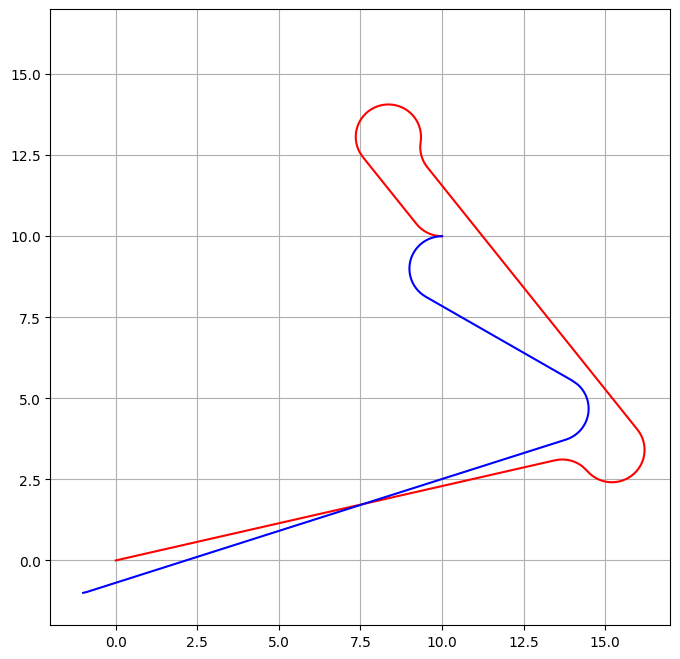

In [9]:
plt.figure(figsize=(8, 8))
plt.xlim(-2, 17)
plt.ylim(-2, 17)
plt.plot([x for (x, y) in path_cpp], [y for (x, y) in path_cpp], color='red')
plt.plot([x for (x, y) in path], [y for (x, y) in path], color='blue')

# plt.scatter([x for (x, y) in path], [y for (x, y) in path])
plt.grid(True)
plt.show()

In [10]:
import numpy as np
from dubins_planner import DubinsPath
import matplotlib.pyplot as plt

In [11]:
dubins = DubinsPath()

In [12]:
start_x = 1.0  # [m]
start_y = 1.0  # [m]
start_yaw = np.deg2rad(45.0)  # [rad]

end_x = -3.0  # [m]
end_y = -3.0  # [m]
end_yaw = np.deg2rad(-45.0)  # [rad]

curvature = 1.0

path_x, path_y, path_yaw, mode, lengths = dubins.plan_dubins_path(start_x,
                                                                  start_y,
                                                                  start_yaw,
                                                                  end_x,
                                                                  end_y,
                                                                  end_yaw,
                                                                  curvature)

In [13]:
path_x

array([ 1.        ,  1.0670603 ,  1.12638537,  1.17738247,  1.21954204,
        1.25244285,  1.27575615,  1.28924901,  1.29278661,  1.28633361,
        1.26995448,  1.24381288,  1.20817   ,  1.16338198,  1.10989632,
        1.04824744,  0.97905131,  0.90299932,  0.82085134,  0.73342818,
        0.64160335,  0.54629431,  0.44845338,  0.34905814,  0.24910172,
        0.14958285,  0.05149589, -0.04417911, -0.1364862 , -0.22450306,
       -0.30735027, -0.38420005, -0.45428454, -0.54691136, -0.60120024,
       -0.65548912, -0.709778  , -0.76406689, -0.81835577, -0.87264465,
       -0.92693353, -0.98122242, -1.0355113 , -1.08980018, -1.14408906,
       -1.19837794, -1.25266683, -1.30695571, -1.36124459, -1.41553347,
       -1.46982235, -1.52411124, -1.57840012, -1.632689  , -1.68697788,
       -1.74126677, -1.79555565, -1.84984453, -1.90413341, -1.95842229,
       -2.01271118, -2.06700006, -2.12128894, -2.17557782, -2.2298667 ,
       -2.28415559, -2.33844447, -2.39273335, -2.44702223, -2.50

In [14]:
path_y

array([ 1.        ,  1.07412547,  1.15457549,  1.24054621,  1.33117866,
        1.42556725,  1.52276889,  1.62181238,  1.7217081 ,  1.82145793,
        1.9200652 ,  2.01654466,  2.10993231,  2.19929507,  2.28374005,
        2.3624235 ,  2.43455923,  2.49942651,  2.55637719,  2.60484224,
        2.64433741,  2.67446808,  2.6949332 ,  2.70552829,  2.70614747,
        2.69678458,  2.67753315,  2.64858553,  2.61023098,  2.56285271,
        2.5069241 ,  2.44300399,  2.37173103,  2.2499956 ,  2.16601514,
        2.08203469,  1.99805423,  1.91407377,  1.83009331,  1.74611286,
        1.6621324 ,  1.57815194,  1.49417148,  1.41019103,  1.32621057,
        1.24223011,  1.15824965,  1.07426919,  0.99028874,  0.90630828,
        0.82232782,  0.73834736,  0.65436691,  0.57038645,  0.48640599,
        0.40242553,  0.31844508,  0.23446462,  0.15048416,  0.0665037 ,
       -0.01747676, -0.10145721, -0.18543767, -0.26941813, -0.35339859,
       -0.43737904, -0.5213595 , -0.60533996, -0.68932042, -0.77

In [15]:
path_yaw

array([ 0.78539816,  0.88539816,  0.98539816,  1.08539816,  1.18539816,
        1.28539816,  1.38539816,  1.48539816,  1.58539816,  1.68539816,
        1.78539816,  1.88539816,  1.98539816,  2.08539816,  2.18539816,
        2.28539816,  2.38539816,  2.48539816,  2.58539816,  2.68539816,
        2.78539816,  2.88539816,  2.98539816,  3.08539816, -3.09778714,
       -2.99778714, -2.89778714, -2.79778714, -2.69778714, -2.59778714,
       -2.49778714, -2.39778714, -2.29778714, -2.1446695 , -2.1446695 ,
       -2.1446695 , -2.1446695 , -2.1446695 , -2.1446695 , -2.1446695 ,
       -2.1446695 , -2.1446695 , -2.1446695 , -2.1446695 , -2.1446695 ,
       -2.1446695 , -2.1446695 , -2.1446695 , -2.1446695 , -2.1446695 ,
       -2.1446695 , -2.1446695 , -2.1446695 , -2.1446695 , -2.1446695 ,
       -2.1446695 , -2.1446695 , -2.1446695 , -2.1446695 , -2.1446695 ,
       -2.1446695 , -2.1446695 , -2.1446695 , -2.1446695 , -2.1446695 ,
       -2.1446695 , -2.1446695 , -2.1446695 , -2.1446695 , -2.14

In [16]:
cpp_path_x = [1, 1.06706, 1.12639, 1.17738, 1.21954, 1.25244, 1.27576, 1.28925, 1.29279, 1.28633, 1.26995, 1.24381, 1.20817, 1.16338, 1.1099, 1.04825, 0.979051, 0.902999, 0.820851, 0.733428, 0.641603, 0.546294, 0.448453, 0.349058, 0.249102, 0.149583, 0.0514959, -0.0441791, -0.136486, -0.224503, -0.30735, -0.3842, -0.454285, -0.546911, -0.6012, -0.655489, -0.709778, -0.764067, -0.818356, -0.872645, -0.926934, -0.981222, -1.03551, -1.0898, -1.14409, -1.19838, -
              1.25267, -1.30696, -1.36124, -1.41553, -1.46982, -1.52411, -1.5784, -1.63269, -1.68698, -1.74127, -1.79556, -1.84984, -1.90413, -1.95842, -2.01271, -2.067, -2.12129, -2.17558, -2.22987, -2.28416, -2.33844, -2.39273, -2.44702, -2.50131, -2.5556, -2.60989, -2.66418, -2.71847, -2.77276, -2.82704, -2.88133, -2.93562, -2.98991, -3.0442, -3.1327, -3.1827, -3.22381, -3.25562, -3.27782, -3.29017, -3.29255, -3.28495, -3.26744, -3.24018, -3.20347, -3.15765, -3.1032, -3]
cpp_path_y = [1, 1.07413, 1.15458, 1.24055, 1.33118, 1.42557, 1.52277, 1.62181, 1.72171, 1.82146, 1.92007, 2.01654, 2.10993, 2.1993, 2.28374, 2.36242, 2.43456, 2.49943, 2.55638, 2.60484, 2.64434, 2.67447, 2.69493, 2.70553, 2.70615, 2.69678, 2.67753, 2.64859, 2.61023, 2.56285, 2.50692, 2.443, 2.37173, 2.25, 2.16602, 2.08203, 1.99805, 1.91407, 1.83009, 1.74611, 1.66213, 1.57815, 1.49417, 1.41019, 1.32621, 1.24223, 1.15825, 1.07427, 0.990289,
              0.906308, 0.822328, 0.738347, 0.654367, 0.570386, 0.486406, 0.402426, 0.318445, 0.234465, 0.150484, 0.0665037, -0.0174768, -0.101457, -0.185438, -0.269418, -0.353399, -0.437379, -0.52136, -0.60534, -0.68932, -0.773301, -0.857281, -0.941262, -1.02524, -1.10922, -1.1932, -1.27718, -1.36116, -1.44514, -1.52912, -1.61311, -1.75, -1.83656, -1.92767, -2.02243, -2.11989, -2.21909, -2.31902, -2.41869, -2.5171, -2.61327, -2.70624, -2.79508, -2.8789, -3]

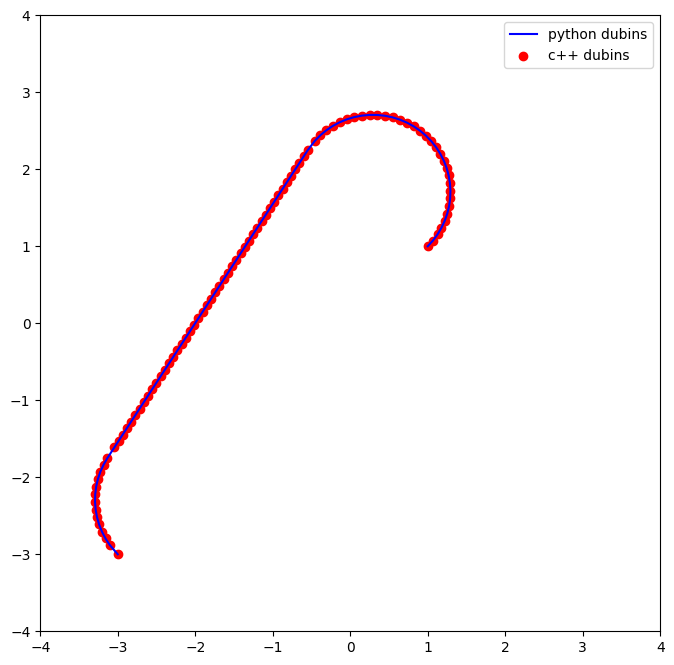

In [17]:
plt.figure(figsize=(8, 8))
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.plot(path_x, path_y, color="blue", label='python dubins')
plt.scatter(cpp_path_x, cpp_path_y, color="red", label='c++ dubins')
plt.legend()
plt.show()

In [18]:
def angle_mod(x, zero_2_2pi=False, degree=False):
    if degree:
        x = x * (np.pi / 180.0)

    if zero_2_2pi:
        mod_angle = x % (2.0 * np.pi)
    else:
        mod_angle = (x + np.pi) % (2.0 * np.pi) - np.pi

    if degree:
        mod_angle = mod_angle * (180.0 / np.pi)

    return mod_angle

In [19]:
angle_mod(3.14, True, False)

3.14

In [20]:
angle_mod(-4.71238898, True, False)

1.5707963271795862

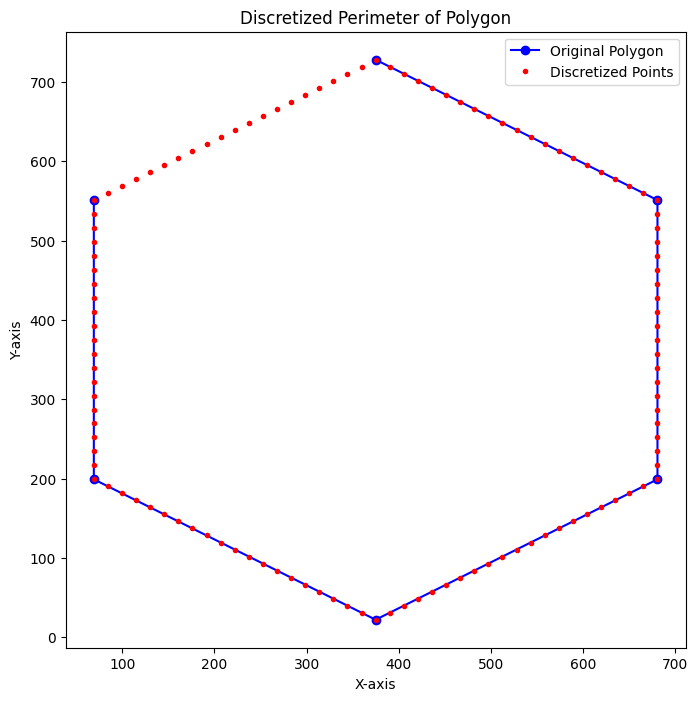

In [21]:
import numpy as np
import matplotlib.pyplot as plt


def discretize_polygon(polygon_vertices, num_points_per_edge):
    points = []

    for i in range(len(polygon_vertices)):
        start_point = polygon_vertices[i]
        # Wrap around for the last edge
        end_point = polygon_vertices[(i + 1) % len(polygon_vertices)]

        x_vals = np.linspace(
            start_point[0], end_point[0], num_points_per_edge, endpoint=False)
        y_vals = np.linspace(
            start_point[1], end_point[1], num_points_per_edge, endpoint=False)

        edge_points = np.column_stack((x_vals, y_vals))
        points.extend(edge_points)

    return np.array(points)


# Example polygon vertices
polygon_vertices = np.array([[69, 551], [69, 199], [375, 22], [
                            681, 199], [681, 551], [375, 728]])

# Discretize the perimeter with 100 points per edge
discretized_points = discretize_polygon(
    polygon_vertices, num_points_per_edge=20)

# Plot the original polygon and the discretized points
plt.figure(figsize=(8, 8))
plt.plot(polygon_vertices[:, 0], polygon_vertices[:,
         1], 'bo-', label='Original Polygon')
plt.plot(discretized_points[:, 0], discretized_points[:,
         1], 'r.', label='Discretized Points')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Discretized Perimeter of Polygon')
plt.legend()
plt.show()

In [22]:
discretized_points

array([[ 69.  , 551.  ],
       [ 69.  , 533.4 ],
       [ 69.  , 515.8 ],
       [ 69.  , 498.2 ],
       [ 69.  , 480.6 ],
       [ 69.  , 463.  ],
       [ 69.  , 445.4 ],
       [ 69.  , 427.8 ],
       [ 69.  , 410.2 ],
       [ 69.  , 392.6 ],
       [ 69.  , 375.  ],
       [ 69.  , 357.4 ],
       [ 69.  , 339.8 ],
       [ 69.  , 322.2 ],
       [ 69.  , 304.6 ],
       [ 69.  , 287.  ],
       [ 69.  , 269.4 ],
       [ 69.  , 251.8 ],
       [ 69.  , 234.2 ],
       [ 69.  , 216.6 ],
       [ 69.  , 199.  ],
       [ 84.3 , 190.15],
       [ 99.6 , 181.3 ],
       [114.9 , 172.45],
       [130.2 , 163.6 ],
       [145.5 , 154.75],
       [160.8 , 145.9 ],
       [176.1 , 137.05],
       [191.4 , 128.2 ],
       [206.7 , 119.35],
       [222.  , 110.5 ],
       [237.3 , 101.65],
       [252.6 ,  92.8 ],
       [267.9 ,  83.95],
       [283.2 ,  75.1 ],
       [298.5 ,  66.25],
       [313.8 ,  57.4 ],
       [329.1 ,  48.55],
       [344.4 ,  39.7 ],
       [359.7 ,  30.85],


In [23]:
# #include <iostream>
# #include <vector>
# #include <Eigen/Dense>

# using namespace Eigen;

# std::vector<Vector2d> discretizePolygon(const std::vector<Vector2d>& polygonVertices, int numPointsPerEdge) {
#     std::vector<Vector2d> points;

#     for (size_t i = 0; i < polygonVertices.size(); ++i) {
#         const Vector2d& startPoint = polygonVertices[i];
#         const Vector2d& endPoint = polygonVertices[(i + 1) % polygonVertices.size()];

#         VectorXd xVals = VectorXd::LinSpaced(numPointsPerEdge, startPoint.x(), endPoint.x());
#         VectorXd yVals = VectorXd::LinSpaced(numPointsPerEdge, startPoint.y(), endPoint.y());

#         MatrixXd edgePoints = Map<MatrixXd>(xVals.data(), numPointsPerEdge, 1).colwise().replicate(1, numPointsPerEdge);
#         edgePoints.rowwise() += yVals.transpose();

#         for (int j = 0; j < numPointsPerEdge; ++j) {
#             points.emplace_back(edgePoints.row(j));
#         }
#     }

#     return points;
# }

# int main() {
#     std::vector<Vector2d> polygonVertices = {
#         Vector2d(69, 551),
#         Vector2d(69, 199),
#         Vector2d(375, 22),
#         Vector2d(681, 199),
#         Vector2d(681, 551),
#         Vector2d(375, 728)
#     };

#     int numPointsPerEdge = 100;

#     std::vector<Vector2d> discretizedPoints = discretizePolygon(polygonVertices, numPointsPerEdge);

#     // Print the discretized points
#     for (const auto& point : discretizedPoints) {
#         std::cout << point.x() << ", " << point.y() << std::endl;
#     }

#     return 0;
# }